In [83]:
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import zipfile
import shutil
import os

from functions import split_data

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
# Downloading origianl implementation and data
!wget --no-check-certificate \
    "https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1" \
    -O "/fsx/python_ml/DeepCFD-TF/DeepCFD.zip"

--2021-02-10 22:47:39--  https://zenodo.org/record/3666056/files/DeepCFD.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179267182 (171M) [application/octet-stream]
Saving to: ‘/fsx/python_ml/DeepCFD-TF/DeepCFD.zip’

100%[======================================>] 179,267,182 48.9MB/s   in 3.7s   

2021-02-10 22:47:43 (46.8 MB/s) - ‘/fsx/python_ml/DeepCFD-TF/DeepCFD.zip’ saved [179267182/179267182]



In [12]:
# Processing the downloaded zip
deepcfd_zip_path = os.path.join(os.getcwd(), 'DeepCFD.zip')
deepcfd_unzip_path = os.path.join(os.getcwd(), 'DeepCFD')
os.mkdir(deepcfd_unzip_path)
shutil.rmtree(deepcfd_unzip_path)
zip_ref = zipfile.ZipFile(deepcfd_zip_path, 'r')
zip_ref.extractall(deepcfd_unzip_path)
zip_ref.close()

In [19]:
print('The contents of the zipfile inlcude:\n-    {}'.format('\n-    '.join(os.listdir('DeepCFD'))))

The contents of the zipfile inlcude:
-    dataX.pkl
-    pytorchtools.py
-    dataY.pkl
-    train_functions.py
-    DeepCFD.py
-    functions.py
-    Models


In [23]:
# Setting up device and loading training data
device_name = '/gpu:0' if tf.config.list_physical_devices('GPU') is not None else '/cpu:0'
device = tf.device(device_name)

x_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataX.pkl')
y_path = os.path.join(os.getcwd(), 'DeepCFD', 'dataY.pkl')
x = pickle.load(open(x_path, 'rb'))
y = pickle.load(open(y_path, 'rb'))

print(f'Using device {device_name}')
print(f'X input has shape of :{x.shape}')
print(f'Y input has shape of :{y.shape}')

Using device /gpu:0
X input has shape of :(981, 3, 172, 79)
Y input has shape of :(981, 3, 172, 79)


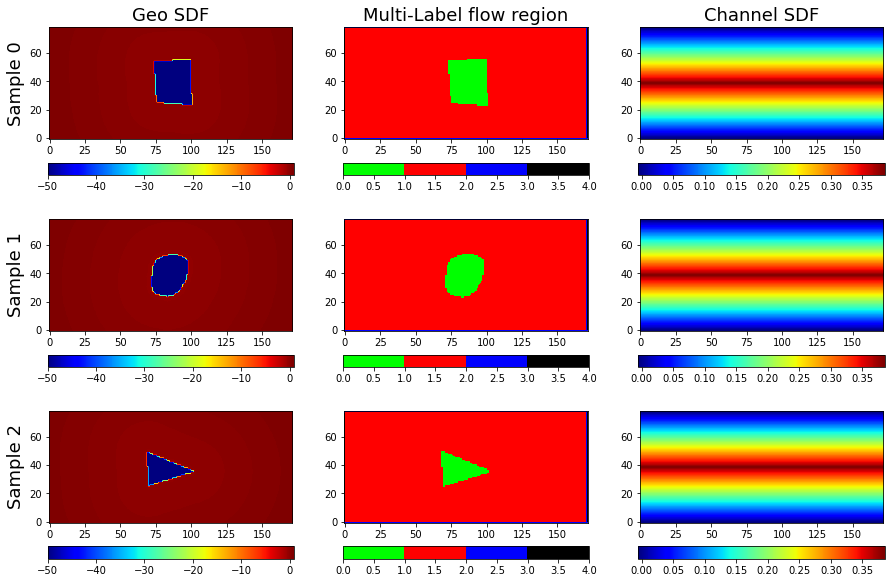

In [74]:
# visualising data
samples = range(3)
colours = [(0, 1, 0), (1, 0, 0), (0, 0, 1), (0, 0, 0)]
cmap = LinearSegmentedColormap.from_list('custom_map', colours, N=4)

fig, axs = plt.subplots(3, 3, figsize=(15,10))
for idx, sample in enumerate(samples):
    vmin = np.min(x[idx][0])
    vmax = np.max(x[idx][0])
    im = axs[idx, 0].imshow(np.transpose(x[idx][0]), cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,0])

    vmin = np.min(x[idx][1])
    vmax = np.max(x[idx][1])
    im = axs[idx,1].imshow(np.transpose(x[idx][1]), cmap=cmap, vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,1])

    vmin = np.min(x[idx][2])
    vmax = np.max(x[idx][2])
    im = axs[idx,2].imshow(np.transpose(x[idx][2]), cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,2])

axs[0,0].set_title('Geo SDF', fontsize=18)
axs[0,1].set_title('Multi-Label flow region', fontsize=18)
axs[0,2].set_title('Channel SDF', fontsize=18)

axs[0,0].set_ylabel(f'Sample {samples[0]}', fontsize=18)
axs[1,0].set_ylabel(f'Sample {samples[1]}', fontsize=18)
axs[2,0].set_ylabel(f'Sample {samples[2]}', fontsize=18)

fig.show()

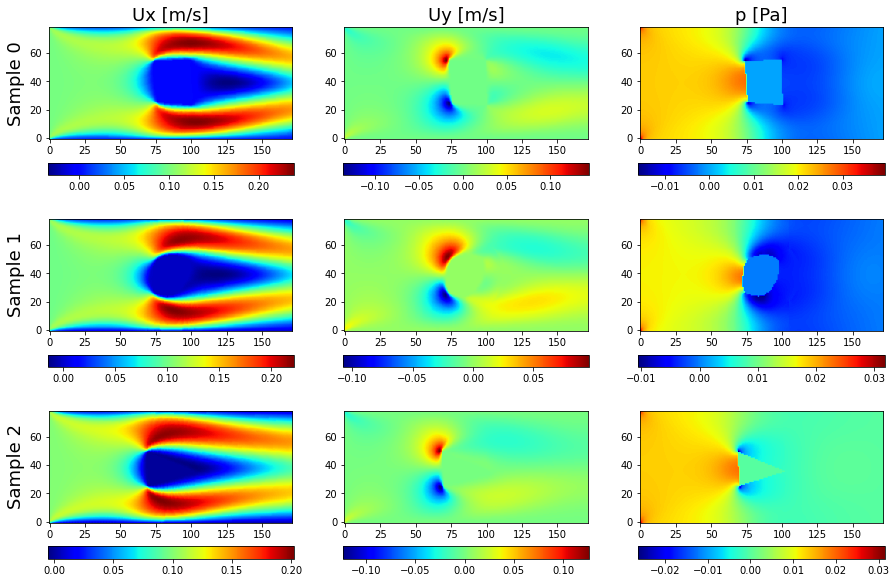

In [75]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
for idx, sample in enumerate(samples):
    vmin = np.min(y[idx][0])
    vmax = np.max(y[idx][0])
    im = axs[idx, 0].imshow(np.transpose(y[idx][0]), cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,0])

    vmin = np.min(y[idx][1])
    vmax = np.max(y[idx][1])
    im = axs[idx,1].imshow(np.transpose(y[idx][1]), cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,1])

    vmin = np.min(y[idx][2])
    vmax = np.max(y[idx][2])
    im = axs[idx,2].imshow(np.transpose(y[idx][2]), cmap='jet', vmin = vmin, vmax = vmax, origin='lower')
    fig.colorbar(im, orientation='horizontal', ax=axs[idx,2])

axs[0,0].set_title('Ux [m/s]', fontsize=18)
axs[0,1].set_title('Uy [m/s]', fontsize=18)
axs[0,2].set_title('p [Pa]', fontsize=18)

axs[0,0].set_ylabel(f'Sample {samples[0]}', fontsize=18)
axs[1,0].set_ylabel(f'Sample {samples[1]}', fontsize=18)
axs[2,0].set_ylabel(f'Sample {samples[2]}', fontsize=18)

fig.show()

In [96]:
# Splitting the data into train and test sets
train_data_x, train_data_y, test_data_x, test_data_y = split_data(x, y, ratio=0.7)

print(f'The shape of the training x data is {train_data_x.shape}')
print(f'The shape of the training y data is {train_data_y.shape}')
print(f'The shape of the testing x data is {test_data_x.shape}')
print(f'The shape of the testing y data is {test_data_y.shape}')

The shape of the training x data is (686, 3, 172, 79)
The shape of the training y data is (686, 3, 172, 79)
The shape of the testing x data is (295, 3, 172, 79)
The shape of the testing y data is (295, 3, 172, 79)


array([[[[ 0.7980621 ,  0.7949109 ,  0.7918711 , ...,  0.7670146 ,
           0.7698819 ,  0.7728644 ],
         [ 0.7885966 ,  0.7854088 ,  0.7823327 , ...,  0.7574226 ,
           0.76032495,  0.7633437 ],
         [ 0.77914387,  0.7759187 ,  0.7728058 , ...,  0.747841  ,
           0.7507792 ,  0.75383514],
         ...,
         [ 0.7253866 ,  0.7222136 ,  0.7191622 , ...,  0.72581893,
           0.72871035,  0.73172307],
         [ 0.73485607,  0.73172307,  0.72871035, ...,  0.73541504,
           0.7382701 ,  0.7412451 ],
         [ 0.7443391 ,  0.7412451 ,  0.7382701 , ...,  0.7450214 ,
           0.747841  ,  0.7507792 ]],

        [[ 2.        ,  3.        ,  3.        , ...,  3.        ,
           3.        ,  2.        ],
         [ 2.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  2.        ],
         [ 2.        ,  1.        ,  1.        , ...,  1.        ,
           1.        ,  2.        ],
         ...,
         [ 2.        ,  1.        